## The problem that I set out to tackle was to cluster the new titles using kmeans and see if I can produce different categories of news topics that were popular during this time period



In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
%cd gdrive/MyDrive/

/content/gdrive/MyDrive


# Import Necessary Libraries

In [2]:
#nltk
#pip install any packages you don't have
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.stem import WordNetLemmatizer
from nltk import punkt

import numpy as np
import pandas as pd
import re, spacy, gensim
import string

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import calinski_harabaz_score

from collections import Counter

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [8]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7MB 7.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 9.9MB 31.6MB/s 
     |████████████████████████████████| 15.3MB 208kB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-cp37-none-any.whl size=136870 sha256=fb71154eda2bae19101a9720d4df1425042ca0ab4717feab9dc85141bd37bed1
  Stored in directory: /root/.cache/pip/wheels/a0/9c/fc/c6e00689d35c82cf96a8adc70edfe7ba7904374fdac3240ac2
Successfully built pyLDAvis
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0

# Load in Dataset

In [3]:
df = pd.read_csv('Eluvio_DS_Challenge.csv')

In [4]:
df.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [5]:
# join the strings of every row
sentences = df['title']
sentences

0                         Scores killed in Pakistan clashes
1                          Japan resumes refuelling mission
2                           US presses Egypt on Gaza border
3              Jump-start economy: Give health care to all 
4           Council of Europe bashes EU&UN terror blacklist
                                ...                        
509231     Heil Trump : Donald Trump s  alt-right  white...
509232    There are people speculating that this could b...
509233            Professor receives Arab Researchers Award
509234    Nigel Farage attacks response to Trump ambassa...
509235    Palestinian wielding knife shot dead in West B...
Name: title, Length: 509236, dtype: object

In [10]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Tokenize and Remove Stop Words

In [11]:
stop = stopwords.words('english')
processed_titles = []
count = -1
for sentence in sentences:
  count +=1
  print(count)
  sentence = word_tokenize(sentence)
  for token in sentence:
    if token in stop or token in string.punctuation:
      sentence.remove(token)
  processed_titles.append(sentence)

Streaming output truncated to the last 5000 lines.
504236
504237
504238
504239
504240
504241
504242
504243
504244
504245
504246
504247
504248
504249
504250
504251
504252
504253
504254
504255
504256
504257
504258
504259
504260
504261
504262
504263
504264
504265
504266
504267
504268
504269
504270
504271
504272
504273
504274
504275
504276
504277
504278
504279
504280
504281
504282
504283
504284
504285
504286
504287
504288
504289
504290
504291
504292
504293
504294
504295
504296
504297
504298
504299
504300
504301
504302
504303
504304
504305
504306
504307
504308
504309
504310
504311
504312
504313
504314
504315
504316
504317
504318
504319
504320
504321
504322
504323
504324
504325
504326
504327
504328
504329
504330
504331
504332
504333
504334
504335
504336
504337
504338
504339
504340
504341
504342
504343
504344
504345
504346
504347
504348
504349
504350
504351
504352
504353
504354
504355
504356
504357
504358
504359
504360
504361
504362
504363
504364
504365
504366
504367
504368
504369
504370
5043

In [12]:
processed_titles[1]

['Japan', 'resumes', 'refuelling', 'mission']

# Lemmatization

In [13]:
#initialize WordNetLemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()

In [14]:
#function to lemmatize text
def lemmatize_text(text):
    lemmatized = []
    for word in text:
        lemmatized.append(lemmatizer.lemmatize(word))
    return lemmatized

In [16]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [17]:
count = -1
for sentence in sentences:
  count += 1
  print(count)
  sentence = lemmatize_text(sentence)

Streaming output truncated to the last 5000 lines.
504236
504237
504238
504239
504240
504241
504242
504243
504244
504245
504246
504247
504248
504249
504250
504251
504252
504253
504254
504255
504256
504257
504258
504259
504260
504261
504262
504263
504264
504265
504266
504267
504268
504269
504270
504271
504272
504273
504274
504275
504276
504277
504278
504279
504280
504281
504282
504283
504284
504285
504286
504287
504288
504289
504290
504291
504292
504293
504294
504295
504296
504297
504298
504299
504300
504301
504302
504303
504304
504305
504306
504307
504308
504309
504310
504311
504312
504313
504314
504315
504316
504317
504318
504319
504320
504321
504322
504323
504324
504325
504326
504327
504328
504329
504330
504331
504332
504333
504334
504335
504336
504337
504338
504339
504340
504341
504342
504343
504344
504345
504346
504347
504348
504349
504350
504351
504352
504353
504354
504355
504356
504357
504358
504359
504360
504361
504362
504363
504364
504365
504366
504367
504368
504369
504370
5043

In [18]:
processed_titles

[['Scores', 'killed', 'Pakistan', 'clashes'],
 ['Japan', 'resumes', 'refuelling', 'mission'],
 ['US', 'presses', 'Egypt', 'Gaza', 'border'],
 ['Jump-start', 'economy', 'Give', 'health', 'care', 'all'],
 ['Council', 'Europe', 'bashes', 'EU', 'UN', 'terror', 'blacklist'],
 ['Hay',
  'presto',
  'Farmer',
  'unveils',
  'illegal',
  'mock-Tudor',
  'castle',
  'tried',
  'hide',
  'behind',
  '40ft',
  'hay',
  'bales'],
 ['Strikes', 'Protests', 'Gridlock', 'the', 'Poland-Ukraine', 'Border'],
 ['The', 'U.N', 'Mismanagement', 'Program'],
 ['Nicolas', 'Sarkozy', 'threatens', 'sue', 'Ryanair'],
 ['US',
  'plans',
  'missile',
  'shields',
  'Polish',
  'town',
  'met',
  'resistance',
  'video'],
 ['Archbishop',
  'Canterbury',
  'calls',
  'new',
  'law',
  'punish',
  'thoughtless',
  'cruel',
  'words',
  '-Times',
  'Online'],
 ['Top',
  'US',
  'Envoy',
  'Violence',
  'In',
  'Kenya',
  'Is',
  'Ethnic',
  'Cleansing'],
 ['Team',
  'building',
  'float',
  'commemorate',
  'Holocaust',

# Remove words less than four letters

In [19]:
# remove words less than four letters
count = -1
remove_short = []
for sentence in processed_titles:
  count +=1
  print(count)
  temp_sent = sentence
  for token in sentence:
    if len(token) < 4:
      temp_sent.remove(token)
  remove_short.append(temp_sent)
remove_short

Streaming output truncated to the last 5000 lines.
504236
504237
504238
504239
504240
504241
504242
504243
504244
504245
504246
504247
504248
504249
504250
504251
504252
504253
504254
504255
504256
504257
504258
504259
504260
504261
504262
504263
504264
504265
504266
504267
504268
504269
504270
504271
504272
504273
504274
504275
504276
504277
504278
504279
504280
504281
504282
504283
504284
504285
504286
504287
504288
504289
504290
504291
504292
504293
504294
504295
504296
504297
504298
504299
504300
504301
504302
504303
504304
504305
504306
504307
504308
504309
504310
504311
504312
504313
504314
504315
504316
504317
504318
504319
504320
504321
504322
504323
504324
504325
504326
504327
504328
504329
504330
504331
504332
504333
504334
504335
504336
504337
504338
504339
504340
504341
504342
504343
504344
504345
504346
504347
504348
504349
504350
504351
504352
504353
504354
504355
504356
504357
504358
504359
504360
504361
504362
504363
504364
504365
504366
504367
504368
504369
504370
5043

[['Scores', 'killed', 'Pakistan', 'clashes'],
 ['Japan', 'resumes', 'refuelling', 'mission'],
 ['presses', 'Egypt', 'Gaza', 'border'],
 ['Jump-start', 'economy', 'Give', 'health', 'care'],
 ['Council', 'Europe', 'bashes', 'UN', 'terror', 'blacklist'],
 ['presto',
  'Farmer',
  'unveils',
  'illegal',
  'mock-Tudor',
  'castle',
  'tried',
  'hide',
  'behind',
  '40ft',
  'bales'],
 ['Strikes', 'Protests', 'Gridlock', 'Poland-Ukraine', 'Border'],
 ['U.N', 'Mismanagement', 'Program'],
 ['Nicolas', 'Sarkozy', 'threatens', 'Ryanair'],
 ['plans', 'missile', 'shields', 'Polish', 'town', 'resistance', 'video'],
 ['Archbishop',
  'Canterbury',
  'calls',
  'law',
  'punish',
  'thoughtless',
  'cruel',
  'words',
  '-Times',
  'Online'],
 ['US', 'Envoy', 'Violence', 'Kenya', 'Ethnic', 'Cleansing'],
 ['Team',
  'building',
  'float',
  'commemorate',
  'Holocaust',
  'De',
  'Jinero',
  'hell',
  'idea'],
 ['Migrant',
  'workers',
  'told',
  'abandon',
  'Lunar',
  'Year',
  'holiday',
  'pla

In [20]:
sentences = remove_short
sentences

[['Scores', 'killed', 'Pakistan', 'clashes'],
 ['Japan', 'resumes', 'refuelling', 'mission'],
 ['presses', 'Egypt', 'Gaza', 'border'],
 ['Jump-start', 'economy', 'Give', 'health', 'care'],
 ['Council', 'Europe', 'bashes', 'UN', 'terror', 'blacklist'],
 ['presto',
  'Farmer',
  'unveils',
  'illegal',
  'mock-Tudor',
  'castle',
  'tried',
  'hide',
  'behind',
  '40ft',
  'bales'],
 ['Strikes', 'Protests', 'Gridlock', 'Poland-Ukraine', 'Border'],
 ['U.N', 'Mismanagement', 'Program'],
 ['Nicolas', 'Sarkozy', 'threatens', 'Ryanair'],
 ['plans', 'missile', 'shields', 'Polish', 'town', 'resistance', 'video'],
 ['Archbishop',
  'Canterbury',
  'calls',
  'law',
  'punish',
  'thoughtless',
  'cruel',
  'words',
  '-Times',
  'Online'],
 ['US', 'Envoy', 'Violence', 'Kenya', 'Ethnic', 'Cleansing'],
 ['Team',
  'building',
  'float',
  'commemorate',
  'Holocaust',
  'De',
  'Jinero',
  'hell',
  'idea'],
 ['Migrant',
  'workers',
  'told',
  'abandon',
  'Lunar',
  'Year',
  'holiday',
  'pla

# KMEANS CLUSTERING

In [21]:
#function to vectorize strings and perform tf-idf transformation
def vectorize_texts(list_of_strings):
    print('Performing vectorization and TF/IDF transformation on texts...')
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(list_of_strings)
    transformer = TfidfTransformer(smooth_idf=False)
    tfidf = transformer.fit_transform(X)
    return tfidf

In [22]:
def cluster_texts(num_clusters, tfidf):
    #perform kmeans clustering for range of clusters
    print('Beginning KMeans Clustering, number of clusters = ', num_clusters, '\n') 
    km = KMeans(n_clusters=num_clusters, max_iter = 100, verbose = 2, n_init = 1).fit(tfidf)
    
    
    return km

In [23]:
concat = []
for sentence in sentences:
  concat.append(' '.join(sentence))
concat

['Scores killed Pakistan clashes',
 'Japan resumes refuelling mission',
 'presses Egypt Gaza border',
 'Jump-start economy Give health care',
 'Council Europe bashes UN terror blacklist',
 'presto Farmer unveils illegal mock-Tudor castle tried hide behind 40ft bales',
 'Strikes Protests Gridlock Poland-Ukraine Border',
 'U.N Mismanagement Program',
 'Nicolas Sarkozy threatens Ryanair',
 'plans missile shields Polish town resistance video',
 'Archbishop Canterbury calls law punish thoughtless cruel words -Times Online',
 'US Envoy Violence Kenya Ethnic Cleansing',
 'Team building float commemorate Holocaust De Jinero hell idea',
 'Migrant workers told abandon Lunar Year holiday plans',
 'Sarkozy Girlfriend Ryanair Over',
 'Nicolas Sarkozy Angela Merkel confirm opposition Turkey membership',
 'Mass Evacuations Continue Kenya',
 'Poor Haitians Resort Eating Dirt',
 'European Commission takes Greece court environment infringements',
 'Rambo banned Burma',
 'Possible Guantanamo soil video',

In [24]:
#vectorized the list of sentences
documents_vectorized = vectorize_texts(concat)

Performing vectorization and TF/IDF transformation on texts...


In [26]:
from sklearn.cluster import KMeans

# Run Clustering for range of K's

In [27]:
kmeans3 = cluster_texts(3, documents_vectorized)

Beginning KMeans Clustering, number of clusters =  3 



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: D

Initialization complete
Iteration  0, inertia 1007289.001
Iteration  1, inertia 506406.369
Iteration  2, inertia 506257.489
Iteration  3, inertia 506150.100
Iteration  4, inertia 506030.620
Iteration  5, inertia 505999.058
Iteration  6, inertia 505997.561
Iteration  7, inertia 505996.976
Iteration  8, inertia 505995.917
Iteration  9, inertia 505991.252
Iteration 10, inertia 505968.721
Iteration 11, inertia 505957.653
Iteration 12, inertia 505957.219
Iteration 13, inertia 505957.064
Iteration 14, inertia 505956.996
Iteration 15, inertia 505956.972
Iteration 16, inertia 505956.964
Iteration 17, inertia 505956.960
Iteration 18, inertia 505956.958
Iteration 19, inertia 505956.957
Iteration 20, inertia 505956.956
Iteration 21, inertia 505956.956
Iteration 22, inertia 505956.956
Iteration 23, inertia 505956.956
Iteration 24, inertia 505956.955
Iteration 25, inertia 505956.955
Iteration 26, inertia 505956.954
Converged at iteration 26: center shift 0.000000e+00 within tolerance 1.159533e-09


In [28]:
kmeans4 = cluster_texts(4, documents_vectorized)

Beginning KMeans Clustering, number of clusters =  4 



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: D

Initialization complete
Iteration  0, inertia 999854.235
Iteration  1, inertia 506000.832
Iteration  2, inertia 505835.635
Iteration  3, inertia 505771.289
Iteration  4, inertia 505753.199
Iteration  5, inertia 505705.110
Iteration  6, inertia 505686.514
Iteration  7, inertia 505686.412
Iteration  8, inertia 505686.405
Iteration  9, inertia 505686.402
Iteration 10, inertia 505686.401
Iteration 11, inertia 505686.400
Iteration 12, inertia 505686.400
Iteration 13, inertia 505686.400
Converged at iteration 13: center shift 0.000000e+00 within tolerance 1.159533e-09


In [29]:
kmeans5 = cluster_texts(5, documents_vectorized)

Beginning KMeans Clustering, number of clusters =  5 



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: D

Initialization complete
Iteration  0, inertia 1000152.508
Iteration  1, inertia 506020.645
Iteration  2, inertia 505877.502
Iteration  3, inertia 505615.333
Iteration  4, inertia 505337.790
Iteration  5, inertia 505025.155
Iteration  6, inertia 504918.245
Iteration  7, inertia 504913.025
Iteration  8, inertia 504912.515
Iteration  9, inertia 504912.402
Iteration 10, inertia 504912.371
Iteration 11, inertia 504912.361
Iteration 12, inertia 504912.358
Iteration 13, inertia 504912.358
Iteration 14, inertia 504912.358
Converged at iteration 14: center shift 0.000000e+00 within tolerance 1.159533e-09


In [30]:
kmeans6 = cluster_texts(6, documents_vectorized)

Beginning KMeans Clustering, number of clusters =  6 



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: D

Initialization complete
Iteration  0, inertia 994521.486
Iteration  1, inertia 504975.190
Iteration  2, inertia 504265.125
Iteration  3, inertia 504087.517
Iteration  4, inertia 503889.872
Iteration  5, inertia 503630.880
Iteration  6, inertia 503515.544
Iteration  7, inertia 503507.190
Iteration  8, inertia 503506.859
Iteration  9, inertia 503506.730
Iteration 10, inertia 503506.663
Iteration 11, inertia 503506.605
Iteration 12, inertia 503506.566
Iteration 13, inertia 503506.540
Iteration 14, inertia 503506.522
Iteration 15, inertia 503506.514
Iteration 16, inertia 503506.510
Iteration 17, inertia 503506.509
Iteration 18, inertia 503506.508
Iteration 19, inertia 503506.508
Iteration 20, inertia 503506.508
Iteration 21, inertia 503506.508
Converged at iteration 21: center shift 0.000000e+00 within tolerance 1.159533e-09


In [31]:
kmeans7 = cluster_texts(7, documents_vectorized)

Beginning KMeans Clustering, number of clusters =  7 



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: D

Initialization complete
Iteration  0, inertia 994261.132
Iteration  1, inertia 505502.665
Iteration  2, inertia 504738.073
Iteration  3, inertia 504451.988
Iteration  4, inertia 504335.975
Iteration  5, inertia 504266.492
Iteration  6, inertia 504204.813
Iteration  7, inertia 504158.395
Iteration  8, inertia 504133.014
Iteration  9, inertia 504091.092
Iteration 10, inertia 504033.102
Iteration 11, inertia 504001.853
Iteration 12, inertia 503979.490
Iteration 13, inertia 503956.025
Iteration 14, inertia 503954.299
Iteration 15, inertia 503954.023
Iteration 16, inertia 503953.877
Iteration 17, inertia 503953.782
Iteration 18, inertia 503953.715
Iteration 19, inertia 503953.635
Iteration 20, inertia 503953.533
Iteration 21, inertia 503953.385
Iteration 22, inertia 503953.162
Iteration 23, inertia 503952.880
Iteration 24, inertia 503952.609
Iteration 25, inertia 503952.400
Iteration 26, inertia 503952.291
Iteration 27, inertia 503952.237
Iteration 28, inertia 503952.213
Iteration 29, inert

In [32]:
kmeans8 = cluster_texts(8, documents_vectorized)

Beginning KMeans Clustering, number of clusters =  8 



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: D

Initialization complete
Iteration  0, inertia 989174.907
Iteration  1, inertia 504577.898
Iteration  2, inertia 503771.988
Iteration  3, inertia 503557.556
Iteration  4, inertia 503432.709
Iteration  5, inertia 503152.649
Iteration  6, inertia 502857.987
Iteration  7, inertia 502792.534
Iteration  8, inertia 502741.673
Iteration  9, inertia 502728.599
Iteration 10, inertia 502713.341
Iteration 11, inertia 502690.426
Iteration 12, inertia 502688.803
Iteration 13, inertia 502688.789
Iteration 14, inertia 502688.788
Iteration 15, inertia 502688.788
Converged at iteration 15: center shift 0.000000e+00 within tolerance 1.159533e-09


In [33]:
kmeans9 = cluster_texts(9, documents_vectorized)

Beginning KMeans Clustering, number of clusters =  9 



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: D

Initialization complete
Iteration  0, inertia 986734.877
Iteration  1, inertia 504415.212
Iteration  2, inertia 503441.371
Iteration  3, inertia 502889.214
Iteration  4, inertia 502632.307
Iteration  5, inertia 502532.503
Iteration  6, inertia 502454.532
Iteration  7, inertia 502398.543
Iteration  8, inertia 502303.457
Iteration  9, inertia 502255.773
Iteration 10, inertia 502212.089
Iteration 11, inertia 502162.537
Iteration 12, inertia 502158.777
Iteration 13, inertia 502158.457
Iteration 14, inertia 502158.241
Iteration 15, inertia 502158.060
Iteration 16, inertia 502157.888
Iteration 17, inertia 502157.760
Iteration 18, inertia 502157.658
Iteration 19, inertia 502157.580
Iteration 20, inertia 502157.525
Iteration 21, inertia 502157.496
Iteration 22, inertia 502157.479
Iteration 23, inertia 502157.469
Iteration 24, inertia 502157.460
Iteration 25, inertia 502157.453
Iteration 26, inertia 502157.446
Iteration 27, inertia 502157.439
Iteration 28, inertia 502157.430
Iteration 29, inert

In [34]:
kmeans10 = cluster_texts(10, documents_vectorized)

Beginning KMeans Clustering, number of clusters =  10 



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: D

Initialization complete
Iteration  0, inertia 983780.660
Iteration  1, inertia 503593.701
Iteration  2, inertia 502850.375
Iteration  3, inertia 502377.715
Iteration  4, inertia 502067.103
Iteration  5, inertia 501801.852
Iteration  6, inertia 501632.882
Iteration  7, inertia 501573.315
Iteration  8, inertia 501495.013
Iteration  9, inertia 501447.780
Iteration 10, inertia 501354.596
Iteration 11, inertia 501314.985
Iteration 12, inertia 501314.401
Iteration 13, inertia 501314.122
Iteration 14, inertia 501313.932
Iteration 15, inertia 501313.845
Iteration 16, inertia 501313.828
Iteration 17, inertia 501313.824
Iteration 18, inertia 501313.823
Iteration 19, inertia 501313.823
Iteration 20, inertia 501313.823
Converged at iteration 20: center shift 0.000000e+00 within tolerance 1.159533e-09


In [35]:
kmeans11 = cluster_texts(11, documents_vectorized)

Beginning KMeans Clustering, number of clusters =  11 



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: D

Initialization complete
Iteration  0, inertia 979274.140
Iteration  1, inertia 503252.166
Iteration  2, inertia 501525.577
Iteration  3, inertia 500846.380
Iteration  4, inertia 500609.067
Iteration  5, inertia 500544.396
Iteration  6, inertia 500510.616
Iteration  7, inertia 500481.276
Iteration  8, inertia 500474.680
Iteration  9, inertia 500467.263
Iteration 10, inertia 500462.528
Iteration 11, inertia 500459.913
Iteration 12, inertia 500453.595
Iteration 13, inertia 500432.308
Iteration 14, inertia 500419.297
Iteration 15, inertia 500419.082
Iteration 16, inertia 500419.059
Iteration 17, inertia 500419.051
Iteration 18, inertia 500419.045
Iteration 19, inertia 500419.041
Iteration 20, inertia 500419.038
Iteration 21, inertia 500419.034
Iteration 22, inertia 500419.028
Iteration 23, inertia 500419.017
Iteration 24, inertia 500419.006
Iteration 25, inertia 500418.999
Iteration 26, inertia 500418.989
Iteration 27, inertia 500418.975
Iteration 28, inertia 500418.959
Iteration 29, inert

In [36]:
kmeans12 = cluster_texts(12, documents_vectorized)

Beginning KMeans Clustering, number of clusters =  12 



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: D

Initialization complete
Iteration  0, inertia 976348.756
Iteration  1, inertia 502976.430
Iteration  2, inertia 502029.469
Iteration  3, inertia 501468.806
Iteration  4, inertia 500989.630
Iteration  5, inertia 500615.207
Iteration  6, inertia 500469.756
Iteration  7, inertia 500417.314
Iteration  8, inertia 500406.597
Iteration  9, inertia 500399.566
Iteration 10, inertia 500387.214
Iteration 11, inertia 500353.299
Iteration 12, inertia 500344.672
Iteration 13, inertia 500343.538
Iteration 14, inertia 500342.074
Iteration 15, inertia 500340.277
Iteration 16, inertia 500338.191
Iteration 17, inertia 500335.443
Iteration 18, inertia 500332.086
Iteration 19, inertia 500330.170
Iteration 20, inertia 500329.923
Iteration 21, inertia 500329.894
Iteration 22, inertia 500329.890
Iteration 23, inertia 500329.889
Iteration 24, inertia 500329.888
Iteration 25, inertia 500329.888
Iteration 26, inertia 500329.888
Iteration 27, inertia 500329.887
Iteration 28, inertia 500329.887
Iteration 29, inert

In [38]:
import pickle

In [41]:
#save kmeans12 model for further use
pickle.dump(kmeans12, open("kmeans12.pkl", "wb"))

In [149]:
kmeans_df = pd.DataFrame(columns=['kmeans3', 'kmeans4', 'kmeans5', 'kmeans6', 'kmeans7', 'kmeans8', 'kmeans9', 'kmeans10', 'kmeans11', 'kmeans12'])

In [150]:
kmeans_df['kmeans3'] = kmeans3.labels_
kmeans_df['kmeans4'] = kmeans4.labels_
kmeans_df['kmeans5'] = kmeans5.labels_
kmeans_df['kmeans6'] = kmeans6.labels_
kmeans_df['kmeans7'] = kmeans7.labels_
kmeans_df['kmeans8'] = kmeans8.labels_
kmeans_df['kmeans9'] = kmeans9.labels_
kmeans_df['kmeans10'] = kmeans10.labels_
kmeans_df['kmeans11'] = kmeans11.labels_

In [151]:
kmeans_df['kmeans12'] = kmeans12.labels_

In [153]:
kmeans_df['title'] = concat
kmeans_df

,kmeans3,kmeans4,kmeans5,kmeans6,kmeans7,kmeans8,kmeans9,kmeans10,kmeans11,kmeans12,title
0,2,3,3,3,0,5,3,0,7,9,Scores killed Pakistan clashes
1,1,0,3,1,0,5,0,0,1,3,Japan resumes refuelling mission
2,1,0,3,1,0,5,0,5,1,3,presses Egypt Gaza border
3,1,0,3,1,0,5,0,0,1,3,Jump-start economy Give health care
4,1,0,3,1,0,5,0,0,1,3,Council Europe bashes UN terror blacklist
...,...,...,...,...,...,...,...,...,...,...,...
509231,1,0,3,1,0,5,0,0,1,3,Heil Trump Donald Trump alt-right white nation...
509232,1,0,3,1,0,5,5,0,1,3,There people speculating this could Madeleine ...
509233,1,0,3,1,0,5,0,0,1,3,Professor receives Arab Researchers Award
509234,1,0,3,1,0,4,0,0,5,3,Nigel Farage attacks response Trump ambassador...


In [154]:
print(kmeans_df.shape)
print(df.shape)

(509236, 11)
(509236, 8)


In [155]:
kmeans_df.head()

,kmeans3,kmeans4,kmeans5,kmeans6,kmeans7,kmeans8,kmeans9,kmeans10,kmeans11,kmeans12,title
0,2,3,3,3,0,5,3,0,7,9,Scores killed Pakistan clashes
1,1,0,3,1,0,5,0,0,1,3,Japan resumes refuelling mission
2,1,0,3,1,0,5,0,5,1,3,presses Egypt Gaza border
3,1,0,3,1,0,5,0,0,1,3,Jump-start economy Give health care
4,1,0,3,1,0,5,0,0,1,3,Council Europe bashes UN terror blacklist


In [156]:
#CHECKPOINT --- SAVE TO CSV TO AVOID RUNNING KMEANS FUNCTIONS AGAIN
kmeans_df.to_csv('kmeans_df.csv')

In [157]:
kmeans_df = pd.read_csv('kmeans_df.csv')

In [158]:
kmeans_df['kmeans3'].value_counts()

1    484657
2     13122
0     11457
Name: kmeans3, dtype: int64

In [159]:
kmeans_df['kmeans12'].value_counts()

3     343781
2      24902
5      21151
8      19292
11     17414
6      14797
0      13885
10     13706
9      11301
4      10829
7       9471
1       8707
Name: kmeans12, dtype: int64

[Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10'),
 Text(0, 0, '11')]

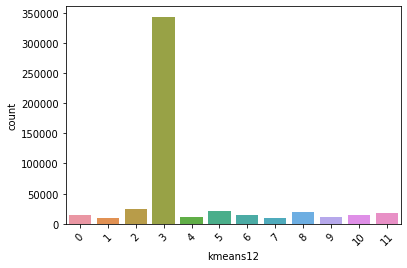

In [160]:
ax = sns.countplot(x= 'kmeans12', data=kmeans_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

In [164]:
#function to find the most common words within each cluster
def get_most_common_words(df, df_column, num_words):
    common_words = []
    for i in range(0,12):
        common = Counter(" ".join(df.loc[df_column == i]['title']).split()).most_common(num_words)
        for j in common:
            dict_ = {}
            dict_['cluster'] = i
            dict_['word'] = j[0]
            common_words.append(dict_)
            
    return common_words

In [165]:
df.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


In [170]:
kmeans_df['title'] = kmeans_df['title'].astype(str)

In [171]:
kmeans_df['title'][15294]

'Great Dane saved burning house collapsed following presumably the shock excitement finding owner still alive'

In [172]:
get_most_common_words(kmeans_df, kmeans_df['kmeans12'], 25)

[{'cluster': 0, 'word': 'government'},
 {'cluster': 0, 'word': 'Government'},
 {'cluster': 0, 'word': 'said'},
 {'cluster': 0, 'word': 'says'},
 {'cluster': 0, 'word': 'country'},
 {'cluster': 0, 'word': 'Syrian'},
 {'cluster': 0, 'word': 'people'},
 {'cluster': 0, 'word': 'the'},
 {'cluster': 0, 'word': 'Chinese'},
 {'cluster': 0, 'word': 'President'},
 {'cluster': 0, 'word': 'protests'},
 {'cluster': 0, 'word': 'forces'},
 {'cluster': 0, 'word': 'U.S.'},
 {'cluster': 0, 'word': 'China'},
 {'cluster': 0, 'word': 'protesters'},
 {'cluster': 0, 'word': 'anti-government'},
 {'cluster': 0, 'word': 'police'},
 {'cluster': 0, 'word': 'British'},
 {'cluster': 0, 'word': 'been'},
 {'cluster': 0, 'word': 'would'},
 {'cluster': 0, 'word': 'opposition'},
 {'cluster': 0, 'word': 'Australian'},
 {'cluster': 0, 'word': 'officials'},
 {'cluster': 0, 'word': 'protest'},
 {'cluster': 0, 'word': 'military'},
 {'cluster': 1, 'word': 'Islamic'},
 {'cluster': 1, 'word': 'State'},
 {'cluster': 1, 'word': '

In [173]:
Counter(" ".join(kmeans_df.loc[kmeans_df['kmeans12'] == 9]['title']).split()).most_common(10)

[('killed', 10213),
 ('people', 1805),
 ('least', 1507),
 ('Killed', 1383),
 ('Syria', 747),
 ('been', 713),
 ('police', 617),
 ('says', 593),
 ('injured', 561),
 ('said', 550)]

In [175]:
df_clusters = pd.concat([df, kmeans_df['kmeans12']], axis = 1, sort = False)

In [176]:
df_clusters.head(100)

,time_created,date_created,up_votes,down_votes,title,over_18,author,category,kmeans12
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews,9
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews,3
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews,3
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews,3
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews,3
...,...,...,...,...,...,...,...,...,...
95,1202579963,2008-02-09,3,0,Iran s nulcear ambitions exposed: US behind it,False,andy4443,worldnews,3
96,1202566445,2008-02-09,0,0,JESSICA ALBA`s way to shoot nude,False,wahabuddin,worldnews,3
97,1202567115,2008-02-09,0,0,AL QAEDA LEADERS ARE NOT OPERATING FROM PAKISTAN,False,wahabuddin,worldnews,3
98,1202588095,2008-02-09,5,0,"White House defends waterboarding, CIA can use...",False,MikaelMN,worldnews,3


In [177]:
kmeans12_cluster3 = pd.DataFrame(df_clusters['kmeans12'].loc[df_clusters['kmeans12'] == 3])

In [178]:
kmeans12_cluster3['title'] = kmeans_df['title']

In [179]:
kmeans12_cluster3

,kmeans12,title
1,3,Japan resumes refuelling mission
2,3,presses Egypt Gaza border
3,3,Jump-start economy Give health care
4,3,Council Europe bashes UN terror blacklist
5,3,presto Farmer unveils illegal mock-Tudor castl...
...,...,...
509230,3,conservative slams Johnson arrogant provocatio...
509231,3,Heil Trump Donald Trump alt-right white nation...
509232,3,There people speculating this could Madeleine ...
509233,3,Professor receives Arab Researchers Award


In [180]:
documents_cluster3 = kmeans12_cluster3['title'].to_list()

In [181]:
cluster_3_vectorized = vectorize_texts(documents_cluster3)

Performing vectorization and TF/IDF transformation on texts...


In [182]:
kmeans10_cluster3= cluster_texts(10, cluster_3_vectorized)

Beginning KMeans Clustering, number of clusters =  10 



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: D

Initialization complete
Iteration  0, inertia 667162.536
Iteration  1, inertia 340672.872
Iteration  2, inertia 340154.818
Iteration  3, inertia 339912.941
Iteration  4, inertia 339748.921
Iteration  5, inertia 339682.372
Iteration  6, inertia 339621.542
Iteration  7, inertia 339586.845
Iteration  8, inertia 339570.205
Iteration  9, inertia 339559.079
Iteration 10, inertia 339542.730
Iteration 11, inertia 339527.585
Iteration 12, inertia 339522.143
Iteration 13, inertia 339513.935
Iteration 14, inertia 339504.121
Iteration 15, inertia 339501.715
Iteration 16, inertia 339501.479
Iteration 17, inertia 339501.316
Iteration 18, inertia 339501.123
Iteration 19, inertia 339500.666
Iteration 20, inertia 339499.559
Iteration 21, inertia 339496.640
Iteration 22, inertia 339492.392
Iteration 23, inertia 339488.348
Iteration 24, inertia 339485.468
Iteration 25, inertia 339485.044
Iteration 26, inertia 339485.037
Iteration 27, inertia 339485.036
Iteration 28, inertia 339485.035
Iteration 29, inert

In [183]:
kmeans_10_cluster3 = pd.DataFrame(kmeans10_cluster3.labels_)
kmeans_10_cluster3['title'] = kmeans_df['title']
kmeans_10_cluster3[0].value_counts()

7    249977
0     26919
3     13131
9     11552
4     11229
8      8387
5      7925
6      7817
1      5221
2      1623
Name: 0, dtype: int64

In [184]:
get_most_common_words(kmeans_10_cluster3, kmeans_10_cluster3[0], 25)

[{'cluster': 0, 'word': 'China'},
 {'cluster': 0, 'word': 'says'},
 {'cluster': 0, 'word': 'Syria'},
 {'cluster': 0, 'word': 'Israel'},
 {'cluster': 0, 'word': 'Russia'},
 {'cluster': 0, 'word': 'Iran'},
 {'cluster': 0, 'word': 'U.S.'},
 {'cluster': 0, 'word': 'government'},
 {'cluster': 0, 'word': 'Ukraine'},
 {'cluster': 0, 'word': 'killed'},
 {'cluster': 0, 'word': 'people'},
 {'cluster': 0, 'word': 'police'},
 {'cluster': 0, 'word': 'Korea'},
 {'cluster': 0, 'word': 'the'},
 {'cluster': 0, 'word': 'Israeli'},
 {'cluster': 0, 'word': 'North'},
 {'cluster': 0, 'word': 'Egypt'},
 {'cluster': 0, 'word': 'Syrian'},
 {'cluster': 0, 'word': 'Russian'},
 {'cluster': 0, 'word': 'attack'},
 {'cluster': 0, 'word': 'world'},
 {'cluster': 0, 'word': 'South'},
 {'cluster': 0, 'word': 'India'},
 {'cluster': 0, 'word': 'Pakistan'},
 {'cluster': 0, 'word': 'military'},
 {'cluster': 1, 'word': 'China'},
 {'cluster': 1, 'word': 'Syria'},
 {'cluster': 1, 'word': 'says'},
 {'cluster': 1, 'word': 'Russi